In [1]:
import sqlite3
import pandas as pd
# Conectar a las dos bases de datos
conn1 = sqlite3.connect('database.sqlite')
conn2 = sqlite3.connect('database_contratos.sqlite')

# Función para obtener todas las tablas de una base de datos
def obtener_tablas(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    tablas = pd.read_sql_query(query, conn)
    return tablas['name'].tolist()

# Función para obtener todos los datos de cada tabla
def obtener_datos_tabla(conn, tabla):
    query = f"SELECT * FROM {tabla};"
    return pd.read_sql_query(query, conn)

# Obtener tablas de cada base de datos
tablas_db1 = obtener_tablas(conn1)
tablas_db2 = obtener_tablas(conn2)

# Cargar datos de la base de datos 1
print("\n--- Datos de Database 1 ---")
dfs_db1 = {}
for tabla in tablas_db1:
    df = obtener_datos_tabla(conn1, tabla)
    dfs_db1[tabla] = df
    print(f"\nTabla: {tabla}")
    print(df.head())  # Muestra las primeras filas de cada tabla

# Cargar datos de la base de datos 2
print("\n--- Datos de Database 2 ---")
dfs_db2 = {}
for tabla in tablas_db2:
    df = obtener_datos_tabla(conn2, tabla)
    dfs_db2[tabla] = df
    print(f"\nTabla: {tabla}")
    print(df.head())
conn1.close()
conn2.close()


--- Datos de Database 1 ---

Tabla: apicall
         date_api_call          commerce_id  ask_status  is_related
0  2024-10-21 18:31:16  GdEQ-MGb7-LXHa-y6cd  Successful         1.0
1  2024-10-13 17:12:08  GdEQ-MGb7-LXHa-y6cd  Successful         1.0
2  2024-12-23 01:02:06  Rh2k-J1o7-zndZ-cOo8  Successful         1.0
3  2024-07-11 07:24:35  GdEQ-MGb7-LXHa-y6cd  Successful         1.0
4  2024-06-28 11:43:52  Rh2k-J1o7-zndZ-cOo8  Successful         1.0

Tabla: commerce
           commerce_id  commerce_nit           commerce_name commerce_status  \
0  KaSn-4LHo-m6vC-I4PU     445470636      Innovexa Solutions        Inactive   
1  Vj9W-c4Pm-ja0X-fC1C     452680670     NexaTech Industries          Active   
2  Rh2k-J1o7-zndZ-cOo8     198818316        QuantumLeap Inc.          Active   
3  3VYd-4lzT-mTC3-DQN5      28960112            Zenith Corp.          Active   
4  GdEQ-MGb7-LXHa-y6cd     919341007  FusionWave Enterprises          Active   

                          commerce_email  
0     

In [5]:
# Analisis Exploratorio (EDA)
db_apicall = pd.DataFrame(dfs_db1['apicall'])
db_commerce = pd.DataFrame(dfs_db1['commerce'])
print("Información Tabla Apicall")
db_apicall.info()
print("Información Tabla Commerce")
db_commerce.info()

Información Tabla Apicall
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   date_api_call  1500000 non-null  object 
 1   commerce_id    1500000 non-null  object 
 2   ask_status     1500000 non-null  object 
 3   is_related     1200495 non-null  float64
dtypes: float64(1), object(3)
memory usage: 45.8+ MB
Información Tabla Commerce
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   commerce_id      5 non-null      object
 1   commerce_nit     5 non-null      int64 
 2   commerce_name    5 non-null      object
 3   commerce_status  5 non-null      object
 4   commerce_email   5 non-null      object
dtypes: int64(1), object(4)
memory usage: 332.0+ bytes


In [7]:
# Cambiamos el formato de fecha que incluye horas al formato unicamente de fecha.
# Convertir la columna 'fecha' a datetime
db_apicall['date_api_call']  = pd.to_datetime(db_apicall['date_api_call'])

In [8]:
# Chequeando valores nulos
db_commerce.isnull().sum()

commerce_id        0
commerce_nit       0
commerce_name      0
commerce_status    0
commerce_email     0
dtype: int64

In [9]:
# Contar la frecuencia de cada categoría
conteo = db_apicall['ask_status'].value_counts()
# Quiero hacer, una distribución o grafico de barras, donde muestre las peticiones exitosas según cada id de la empresa y las peticiones nn

In [20]:
union = db_commerce[['commerce_name','commerce_id']]

,commerce_name,commerce_id
0,Innovexa Solutions,KaSn-4LHo-m6vC-I4PU
1,NexaTech Industries,Vj9W-c4Pm-ja0X-fC1C
2,QuantumLeap Inc.,Rh2k-J1o7-zndZ-cOo8
3,Zenith Corp.,3VYd-4lzT-mTC3-DQN5
4,FusionWave Enterprises,GdEQ-MGb7-LXHa-y6cd


In [25]:
agrupacion = db_apicall.groupby(['commerce_id', 'ask_status']).size().unstack(fill_value=0)


In [26]:
union = pd.merge(agrupacion,db_commerce[['commerce_name','commerce_id']],on='commerce_id')

In [27]:
union.iloc[:,1:]

,Successful,Unsuccessful,commerce_name
0,240591,59921,Zenith Corp.
1,239507,60145,FusionWave Enterprises
2,240036,60064,Innovexa Solutions
3,239976,59805,QuantumLeap Inc.
4,240385,59570,NexaTech Industries


In [28]:
import matplotlib.pyplot as plt

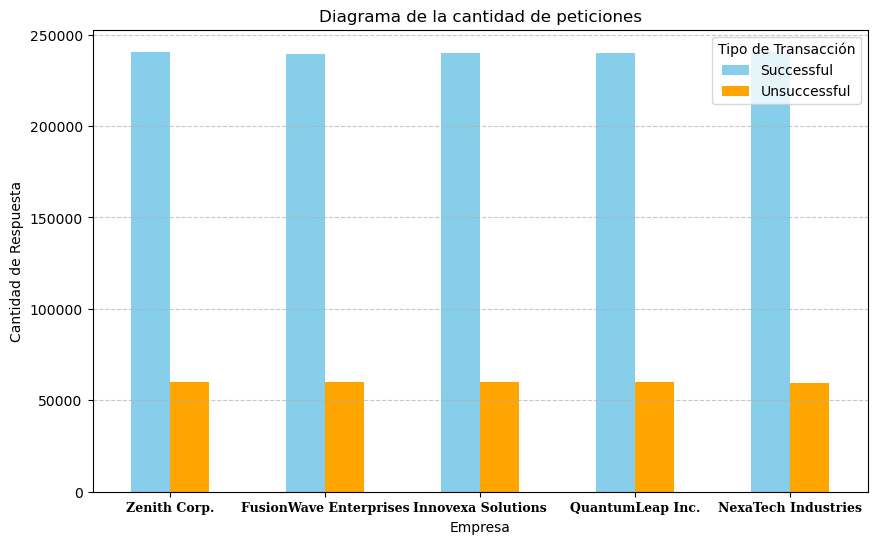

In [58]:
# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
# Graficar especificando la columna para el eje X y las columnas para Y
union.plot(kind='bar', x='commerce_name',color=['skyblue', 'orange'], ax= ax)
plt.xticks(rotation= 0, fontsize=9, fontweight='bold', fontfamily='serif') 
plt.title('Diagrama de la cantidad de peticiones')
plt.xlabel('Empresa', fontsize=10)
plt.ylabel('Cantidad de Respuesta')
plt.legend(title='Tipo de Transacción')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [60]:
db_commerce.describe()

,commerce_nit
count,5.000000e+00
mean,4.090541e+08
std,3.362635e+08
min,2.896011e+07
25%,1.988183e+08
50%,4.454706e+08
75%,4.526807e+08
max,9.193410e+08


In [61]:
db_apicall.describe()

,date_api_call,is_related
count,1500000,1.200495e+06
mean,2024-07-02 00:33:23.949236224,6.671648e-01
min,2024-01-01 00:00:15,0.000000e+00
25%,2024-04-01 16:45:41.500000,0.000000e+00
50%,2024-07-01 23:32:30.500000,1.000000e+00
75%,2024-10-01 10:41:27.500000,1.000000e+00
max,2024-12-31 23:59:39,1.000000e+00
std,NaN,4.712283e-01
